# Feature Extraction using Convolutional Neural Networks
[GitHub Tutorial:CIFAR 10 feature extraction using pretrained convolutional depp neural networks from keras library](https://github.com/rnoxy/cifar10-cnn/blob/master/Feature_extraction_using_keras.ipynb)

In [1]:
#Github code
network_names = [ 'incv3', 'resnet50', 'vgg16', 'vgg19' ]

print("Available networks = ", network_names)
cnnid = int( input("Please choose the CNN network [0-{n}]: ".format(n=len(network_names)-1)) )
selected_network = network_names[cnnid]
print("Selected network: ", selected_network)

Available networks =  ['incv3', 'resnet50', 'vgg16', 'vgg19']
Please choose the CNN network [0-3]: 3
Selected network:  vgg19


In [2]:
 pip install myutils

  Created wheel for myutils: filename=myutils-0.0.21-py3-none-any.whl size=1363 sha256=2f8a4534658a37b527e3c2f7b4d7be1273e22a05cc108cffe06a10a6dcd2986e
  Stored in directory: /root/.cache/pip/wheels/8e/89/9f/ab7f23dcc9ba30d64a298bcfc29c4e7e9ec59110ddc69aac12
Successfully built myutils


In [3]:
#github
import time
import myutils
import numpy as np
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_v2_behavior()
from keras.layers import Input, Dense, AveragePooling2D, GlobalAveragePooling2D
from keras import backend as K

Instructions for updating:
non-resource variables are not supported in the long term


## Load Mnist data

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 3) (60000,) (10000, 28, 28, 3) (10000,)


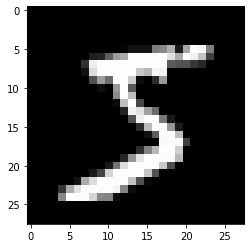

In [4]:
#github
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train=np.stack((X_train,X_train,X_train), axis=3)
X_test=np.stack((X_test,X_test,X_test), axis=3)
n_training = X_train.shape[0]
n_testing = X_test.shape[0]

y_train = y_train.flatten()
y_test  = y_test.flatten()

print( X_train.shape, y_train.shape,  X_test.shape, y_test.shape )

from matplotlib import pyplot as plt
plt.imshow( X_train[0]  )
plt.show()

## Create model

In [5]:
#github
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet     import ResNet50
from keras.applications.vgg16        import VGG16
from keras.applications.vgg19        import VGG19

input_shape = {
    'incv3'   : (299,299,3),
    'resnet50': (224,224,3),
    'vgg16'   : (224,224,3),
    'vgg19'   : (224,224,3)
}[selected_network]

def create_model_incv3():
    tf_input = Input(shape=input_shape)
    model = InceptionV3(input_tensor=tf_input, weights='imagenet', include_top=False)
    output_pooled = AveragePooling2D((8, 8), strides=(8, 8))(model.output)
    return Model(model.input, output_pooled)

def create_model_resnet50():
    tf_input = Input(shape=input_shape)
    return ResNet50(input_tensor=tf_input, include_top=False)

def create_model_vgg16():
    tf_input = Input(shape=input_shape)
    model = VGG16(input_tensor=tf_input, include_top=False)
    output_pooled = AveragePooling2D((7, 7))(model.output)
    return Model(model.input, output_pooled )

def create_model_vgg19():
    tf_input = Input(shape=input_shape)
    model = VGG19(input_tensor=tf_input, include_top=False)
    output_pooled = AveragePooling2D((7, 7))(model.output)
    return Model(model.input, output_pooled )

create_model = {
    'incv3'    : create_model_incv3,
    'resnet50' : create_model_resnet50,
    'vgg16'    : create_model_vgg16,
    'vgg19'    : create_model_vgg19
}[selected_network]

## Data generator for tensorflow

[Tensorflow 1 to 2](https://stackoverflow.com/questions/60966376/best-practice-to-write-code-compatible-to-both-tensorflow-1-and-2)

In [6]:
#github
# tensorflow placeholder for batch of images from CIFAR10 dataset
batch_of_images_placeholder = tf.placeholder("uint8", (None, 28, 28, 3))

batch_size = {
    'incv3'    : 16,
    'resnet50' : 16,
    'vgg16'    : 16,
    'vgg19'    : 16
}[selected_network]

# Inception default size is 299x299
tf_resize_op = tf.image.resize(batch_of_images_placeholder, (input_shape[:2]), method='bilinear')

In [7]:
#github
# data generator for tensorflow session
from keras.applications.inception_v3 import preprocess_input as incv3_preprocess_input
from keras.applications.resnet     import preprocess_input as resnet50_preprocess_input
from keras.applications.vgg16        import preprocess_input as vgg16_preprocess_input
from keras.applications.vgg19        import preprocess_input as vgg19_preprocess_input

preprocess_input = {
    'incv3'   : incv3_preprocess_input,
    'resnet50': resnet50_preprocess_input,
    'vgg16'   : vgg16_preprocess_input,
    'vgg19'   : vgg19_preprocess_input
}[selected_network]

def data_generator(sess,data,labels):
    def generator():
        start = 0
        end = start + batch_size
        n = data.shape[0]
        while True:
            batch_of_images_resized = sess.run(tf_resize_op, {batch_of_images_placeholder: data[start:end]})
            batch_of_images__preprocessed = preprocess_input(batch_of_images_resized)
            batch_of_labels = labels[start:end]
            start += batch_size
            end   += batch_size
            if start >= n:
                start = 0
                end = batch_size
            yield (batch_of_images__preprocessed, batch_of_labels)
    return generator

## Feature extraction

In [8]:
with tf.Session() as sess:
    # setting tensorflow session to Keras
    K.set_session(sess)
    # setting phase to training
    K.set_learning_phase(1)  # 0 - test,  1 - train

    model = create_model()

    data_train_gen = data_generator(sess, X_train, y_train)
    ftrs_training = model.predict_generator(data_train_gen(), n_training/batch_size, verbose=1)

    data_test_gen = data_generator(sess, X_test, y_test)
    ftrs_testing = model.predict_generator(data_test_gen(), n_testing/batch_size, verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:414: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


80150528/80134624 [==============================] - 2s 0us/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]


In [9]:
#github
features_training = np.array( [ftrs_training[i].flatten() for i in range(n_training)] )
features_testing  = np.array( [ftrs_testing[i].flatten()  for i in range(n_testing )] )

#np.savez_compressed("features/CIFAR10_{}-keras_features.npz".format(selected_network),features_training=features_training,features_testing=features_testing,labels_training=y_train,labels_testing=y_test)

In [ ]:
#github
features_training.shape, features_testing.shape

((50000, 512), (10000, 512))

In [ ]:
#github
print('Ten first features of X_train[0] (see figure above, with the frog)')
features_training[0][0:10]

Ten first features of X_train[0] (see figure above, with the frog)


array([4.984349  , 2.1439927 , 0.7077353 , 0.1357666 , 0.10525085,
       1.9851164 , 0.6462987 , 1.8137113 , 2.987951  , 0.        ],
      dtype=float32)

## Feature visualization

### Feature analysis (using PCA)

In [10]:
#github
import numpy as np
import myutils

#data = np.load("features/CIFAR10_{}-keras_features.npz".format(selected_network))

X_training = features_training
y_training = y_train

X_testing = features_testing
y_testing = y_test

# data_training, data_testing = myutils.load_CIFAR_dataset(shuffle=False)
# assert( (np.array( [data_training[i][1] for i in range(len(data_training))] ) == y_training).all() )
# assert( (np.array( [data_testing[i][1] for i in range(len(data_testing))] ) == y_testing).all() )
print( 'X_training size = {}'.format(X_training.shape))

X_training size = (60000, 512)


In [11]:
#github
from sklearn import decomposition

pca = decomposition.PCA(n_components=500)
pca.fit(X_training)

PCA(n_components=500)

In [12]:
#github
X = pca.transform(X_training)

In [ ]:
#github
X.shape

(50000, 2)

# Classifier

In [13]:
from sklearn.preprocessing import LabelBinarizer

Y_train=LabelBinarizer().fit_transform(y_train)
Y_test=LabelBinarizer().fit_transform(y_test)

In [17]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier()

In [15]:
#Please see the following website for reference
#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 50, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [16]:
from sklearn.model_selection import RandomizedSearchCV

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
model_random= RandomizedSearchCV(estimator=model,param_distributions= random_grid, n_iter=100, cv = 3, verbose=2, n_jobs=-1)

In [19]:
model_random.fit(X,Y_train)
model_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'bootstrap': False,
 'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 50}

In [19]:
from sklearn.model_selection import GridSearchCV

# Create the random grid
param_grid = {
    'n_estimators': [35,50],
    'max_features': ['auto','sqrt'],
    'max_depth': [40,50,110],
    'min_samples_split': [2,5],
    'min_samples_leaf': [1,2],
    'bootstrap': [False]
}
print(param_grid)

{'n_estimators': [35, 50], 'max_features': ['auto', 'sqrt'], 'max_depth': [40, 50, 110], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [False]}


In [20]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
model_grid= GridSearchCV(estimator=model,param_grid= param_grid, cv = 3, verbose=2, n_jobs=-1)

In [21]:
model_grid.fit(X,Y_train)
model_grid.best_params_

Fitting 3 folds for each of 48 candidates, totalling 144 fits


{'bootstrap': False,
 'max_depth': 40,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 50}

In [22]:
from sklearn.ensemble import RandomForestClassifier
model_2=RandomForestClassifier(n_estimators=40, max_features='sqrt', max_depth=40, min_samples_split=2, min_samples_leaf=2, bootstrap=False)
TrainedModel=model_2.fit(X,Y_train)

In [24]:
pca.fit(X_testing)
X_t = pca.transform(X_testing)

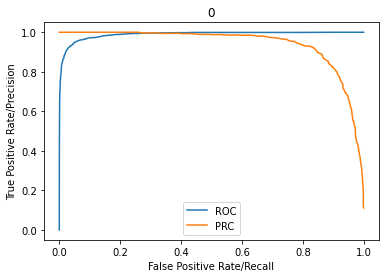

PRC AUC:0.9411671519124736
ROC AUC:0.9888131815919272


In [25]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

probs = TrainedModel.predict_proba(X_t)

probs1=probs[0]
fpr1, tpr1, thresholds1 = roc_curve(Y_test[:,0], probs1[:,1])
prec1, recall1, thresholds1 = precision_recall_curve(Y_test[:,0], probs1[:,1])

plt.plot(fpr1,tpr1,label="ROC")
plt.plot(recall1,prec1,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('0')
plt.show()

print("PRC AUC:" + str(auc(recall1, prec1)))
print("ROC AUC:" + str(auc(fpr1, tpr1)))

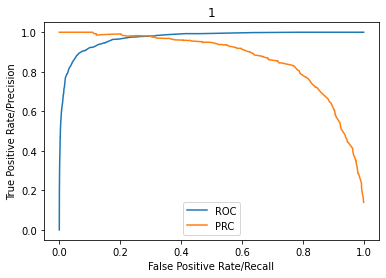

PRC AUC:0.8681985279626117
ROC AUC:0.9712201872929975


In [26]:
probs2=probs[1]
fpr2, tpr2, thresholds2 = roc_curve(Y_test[:,1], probs2[:, 1])
prec2, recall2, thresholds2 = precision_recall_curve(Y_test[:,1], probs2[:, 1])

plt.plot(fpr2,tpr2,label="ROC")
plt.plot(recall2,prec2,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('1')
plt.show()

print("PRC AUC:" + str(auc(recall2, prec2)))
print("ROC AUC:" + str(auc(fpr2, tpr2)))

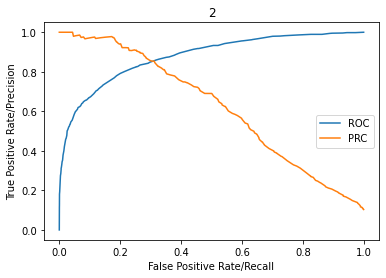

PRC AUC:0.6233046173995358
ROC AUC:0.8771607295361975


In [27]:
probs3=probs[2]
fpr3, tpr3, thresholds3 = roc_curve(Y_test[:,2], probs3[:, 1])
prec3, recall3, thresholds3 = precision_recall_curve(Y_test[:,2], probs3[:, 1])

plt.plot(fpr3,tpr3,label="ROC")
plt.plot(recall3,prec3,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('2')
plt.show()

print("PRC AUC:" + str(auc(recall3, prec3)))
print("ROC AUC:" + str(auc(fpr3, tpr3)))

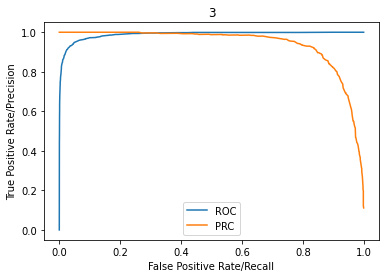

PRC AUC:0.6720125841732689
ROC AUC:0.9266951728543266


In [29]:
probs4=probs[3]
fpr4, tpr4, thresholds4 = roc_curve(Y_test[:,3], probs4[:, 1])
prec4, recall4, thresholds4 = precision_recall_curve(Y_test[:,3], probs4[:, 1])

plt.plot(fpr1,tpr1,label="ROC")
plt.plot(recall1,prec1,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('3')
plt.show()

print("PRC AUC:" + str(auc(recall4, prec4)))
print("ROC AUC:" + str(auc(fpr4, tpr4)))

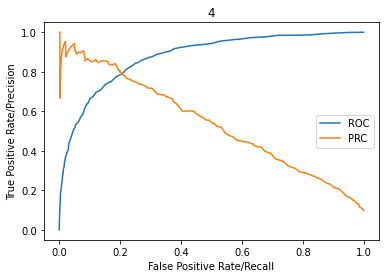

PRC AUC:0.5415417004776649
ROC AUC:0.8780881888632782


In [30]:
probs5=probs[4]
fpr5, tpr5, thresholds5 = roc_curve(Y_test[:,4], probs5[:, 1])
prec5, recall5, thresholds5 = precision_recall_curve(Y_test[:,4], probs5[:, 1])

plt.plot(fpr5,tpr5,label="ROC")
plt.plot(recall5,prec5,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('4')
plt.show()

print("PRC AUC:" + str(auc(recall5, prec5)))
print("ROC AUC:" + str(auc(fpr5, tpr5)))

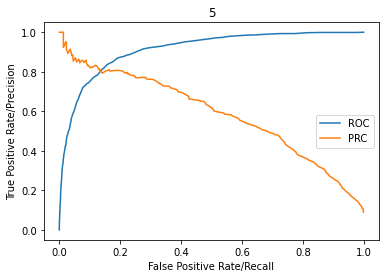

PRC AUC:0.5909070765082087
ROC AUC:0.9130058751878308


In [31]:
probs6=probs[5]
fpr6, tpr6, thresholds6 = roc_curve(Y_test[:,5], probs6[:, 1])
prec6, recall6, thresholds6 = precision_recall_curve(Y_test[:,5], probs6[:, 1])

plt.plot(fpr6,tpr6,label="ROC")
plt.plot(recall6,prec6,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('5')
plt.show()

print("PRC AUC:" + str(auc(recall6, prec6)))
print("ROC AUC:" + str(auc(fpr6, tpr6)))

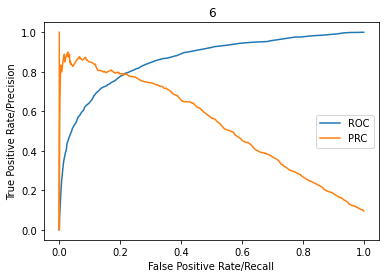

PRC AUC:0.5357029702544388
ROC AUC:0.8638522432314243


In [32]:
probs7=probs[6]
fpr7, tpr7, thresholds7 = roc_curve(Y_test[:,6], probs7[:, 1])
prec7, recall7, thresholds7 = precision_recall_curve(Y_test[:,6], probs7[:, 1])

plt.plot(fpr7,tpr7,label="ROC")
plt.plot(recall7,prec7,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('6')
plt.show()

print("PRC AUC:" + str(auc(recall7, prec7)))
print("ROC AUC:" + str(auc(fpr7, tpr7)))

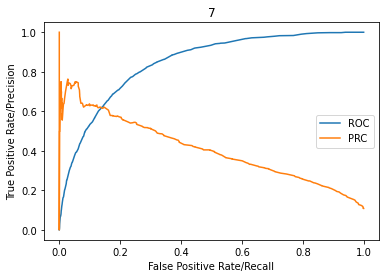

PRC AUC:0.4082251408638503
ROC AUC:0.8451651788269947


In [33]:
probs8=probs[7]
fpr8, tpr8, thresholds8 = roc_curve(Y_test[:,7], probs8[:, 1])
prec8, recall8, thresholds8 = precision_recall_curve(Y_test[:,7], probs8[:, 1])

plt.plot(fpr8,tpr8,label="ROC")
plt.plot(recall8,prec8,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('7')
plt.show()

print("PRC AUC:" + str(auc(recall8, prec8)))
print("ROC AUC:" + str(auc(fpr8, tpr8)))

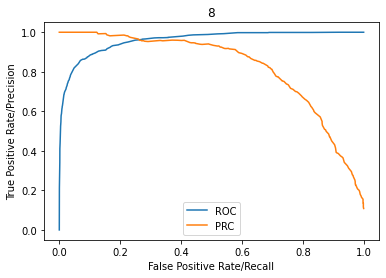

PRC AUC:0.8239533568329097
ROC AUC:0.9598332970096427


In [34]:
probs9=probs[8]
fpr9, tpr9, thresholds9 = roc_curve(Y_test[:,8], probs9[:, 1])
prec9, recall9, thresholds9 = precision_recall_curve(Y_test[:,8], probs9[:, 1])

plt.plot(fpr9,tpr9,label="ROC")
plt.plot(recall9,prec9,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('8')
plt.show()

print("PRC AUC:" + str(auc(recall9, prec9)))
print("ROC AUC:" + str(auc(fpr9, tpr9)))

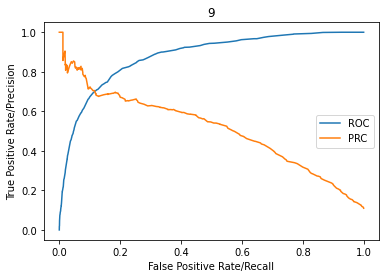

PRC AUC:0.5116177267509119
ROC AUC:0.8790558535630665


In [35]:
probs10=probs[9]
fpr10, tpr10, thresholds10 = roc_curve(Y_test[:,9], probs10[:, 1])
prec10, recall10, thresholds10 = precision_recall_curve(Y_test[:,9], probs10[:, 1])

plt.plot(fpr10,tpr10,label="ROC")
plt.plot(recall10,prec10,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('9')
plt.show()

print("PRC AUC:" + str(auc(recall10, prec10)))
print("ROC AUC:" + str(auc(fpr10, tpr10)))